In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [18]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
len(words)

32033

In [20]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for (i, s) in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for (s, i) in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [36]:
# Context length: how many characters do we take to predict the next one?
block_size = 3

# Build the dataset (with a function)
def build_dataset(words):

    # Input & Output(labels) tensors initialized as empty
    X, Y = [], []
    
    for w in words:
        #print(w)
        # Start with a padded context, of zero context
        # Essentially starting with the empty context with the given block size
        context = [0] * block_size
        # Iterate through each character in the word with the '.' representing the ending token
        for ch in w + '.':
            # Take the index of the current character
            idx = stoi[ch]
            # We store the current running context
            X.append(context)
            # For this current context, we store the label, in other words,
            # The character that we want to predict as being next
            Y.append(idx)
            # Print everything
            #print(''.join(itos[i] for i in context), '--->', itos[idx])
            # Crop the first character of the context and append the new character to the cropped
            context = context[1:] + [idx]
    
    # Convet input and output to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# Sizes of these differ, since we form the dataset based on context embeddings (3 letters each)
# and not the words themselves

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [75]:
# MLP revisited

# The dimensionality of the character embedding vectors
n_embd = 10
# The number of neurons in the hidden layer
n_hidden = 200
# Number of items in vocabulary (letters + .)
vocab_size = len(itos)

# Give a fixed seed for reproducibility
g = torch.Generator().manual_seed(2147483647)
# Build the lookup table for context sequences, which stores the embeddings
C = torch.randn((vocab_size, n_embd), generator=g)
# Initialize weights and biases for the first and the second layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
# Initialize second biases as 0
b2 = torch.randn(vocab_size, generator=g) * 0
# Gather all parameters in a single list
parameters = [C, W1, b1, W2, b2]

# Compute number of parameters
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


tensor(0.0093) tensor(0.9996)
tensor(0.0022) tensor(0.9860)


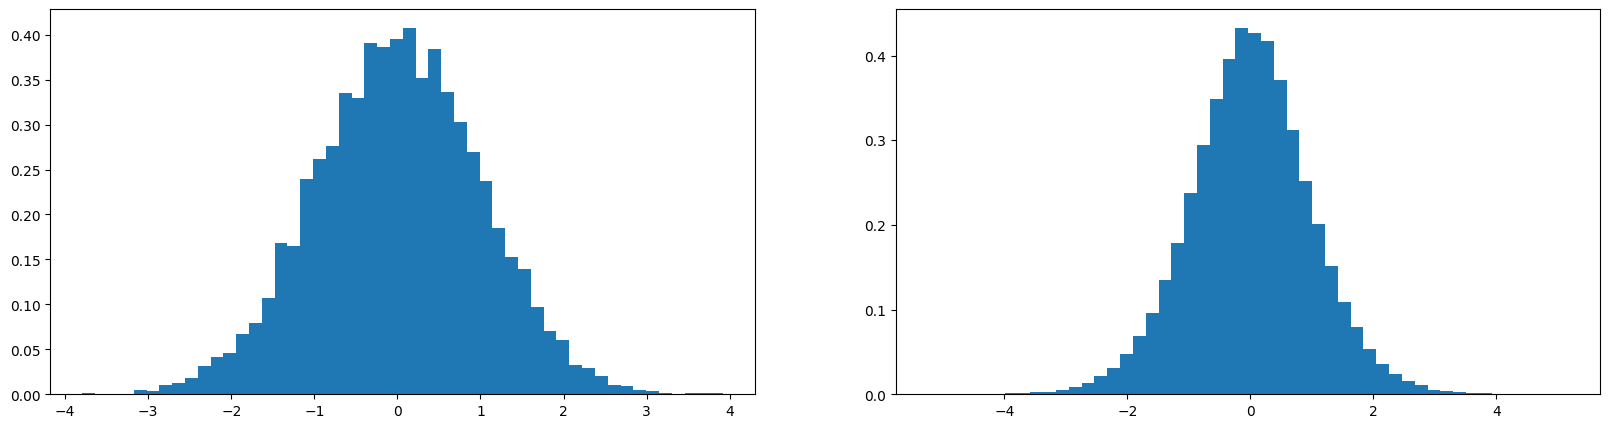

In [83]:
x = torch.randn(1000, 10)
# Dividing by the square root of the input fan size (10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [76]:
# Number of steps to optimize the model
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch construct
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    # Batch X,Y
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    # Forward pass
    # Create the embeddings encodings for all the inputs
    emb = C[Xb] # shape [32, 3, 2]
    # First layer pre-activation
    hpreact = emb.view(-1, n_embd * block_size) @ W1 + b1
    # Apply first layer tanh activation function
    # (vanishing gradient)
    h = torch.tanh(hpreact) # 32, 100
    # Apply second layer
    logits = h @ W2 + b2
    # Count, probs and loss lines above are equal to
    loss = F.cross_entropy(logits, Yb)
    
    #print(loss.item())
    # Backward pass
    # Set the gradients to 0
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    # Dynamically adjust the learning rate
    #lr = lrs[i]
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3026
  10000/ 200000: 2.3652
  20000/ 200000: 2.1524
  30000/ 200000: 2.6354
  40000/ 200000: 2.1904
  50000/ 200000: 2.2418
  60000/ 200000: 2.0820
  70000/ 200000: 1.9691
  80000/ 200000: 1.9906
  90000/ 200000: 2.2204
 100000/ 200000: 2.1536
 110000/ 200000: 1.9418
 120000/ 200000: 2.1180
 130000/ 200000: 2.0590
 140000/ 200000: 1.9726
 150000/ 200000: 1.8978
 160000/ 200000: 1.8839
 170000/ 200000: 2.1710
 180000/ 200000: 1.8882
 190000/ 200000: 2.1592


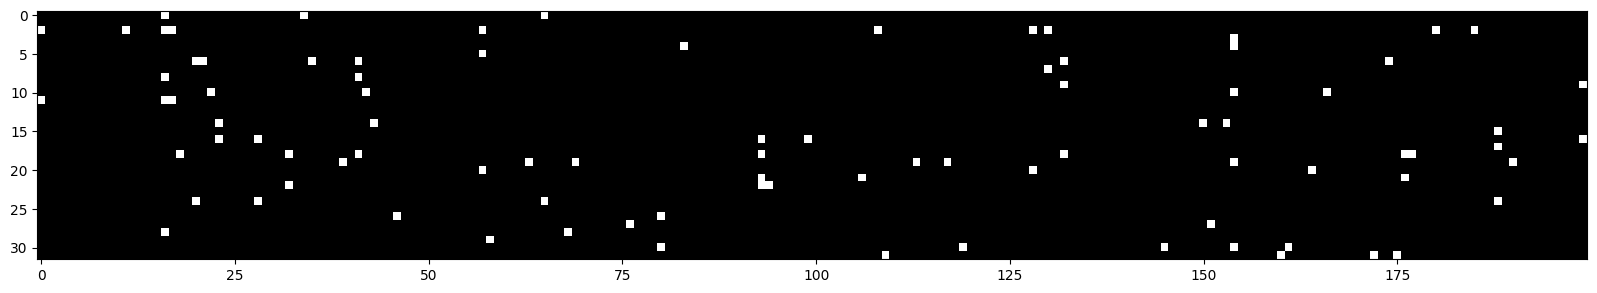

In [71]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99,cmap='gray', interpolation='nearest')

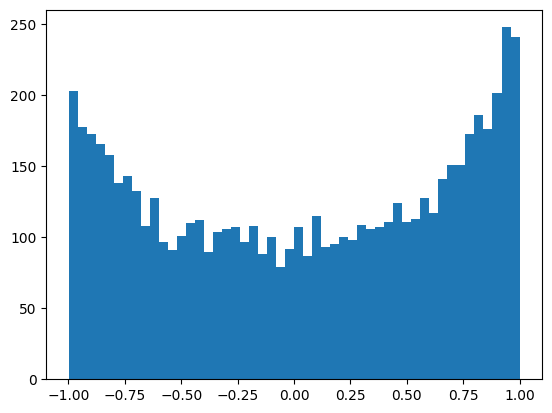

In [72]:
plt.hist(h.view(0-1).tolist(), 50);

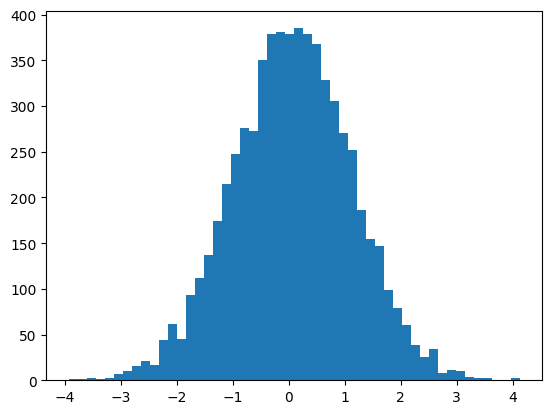

In [73]:
plt.hist(hpreact.view(0-1).tolist(), 50);

In [35]:
# Initially, all characters should have the same probability for generation
# since the model is not trained and it should treat all of the equally
# In this case, the loss we are looking for, should be drawn from 1/27.0
# the uniform probability for our vocabulary size
# As loss, we will use the negative log likelihood
-torch.tensor(1/27.0).log()

# Basically what happens at initialization is that the network is
# Very confidently wrong

# 4-dimensional example of the issue
#logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([9.9999e-01, 4.4315e-08, 6.1948e-15, 5.9301e-06]), tensor(32.7151))

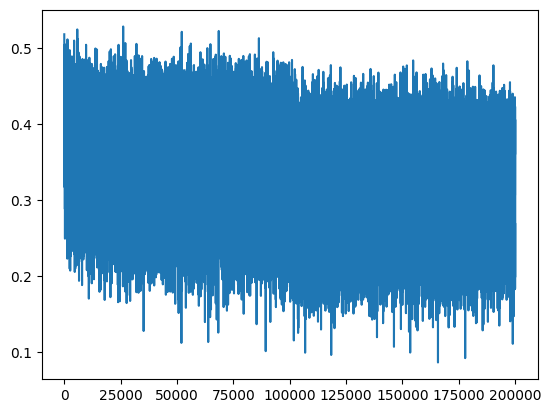

In [51]:
plt.plot(lossi)

In [77]:
# Dsable gradient tracking
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    # Evaluate the loss for the entire dataset after a minibatch multistep train
    emb = C[x] # shape (N, block_size, n_embd)
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # becomes shape (N, block_size * n_embd)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.035724639892578
val 2.09740948677063


In [78]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # Forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    # decode and print the generated word
    print("".join([itos[i] for i in out]))

carmah.
ambrileigh.
mili.
taty.
salaysie.
rahnen.
deliah.
jareen.
ner.
kiah.
maiir.
kaleigh.
ham.
poc.
desian.
sulio.
alian.
quinterra.
jaryn.
kai.
